In [1]:
import warnings
warnings.filterwarnings('ignore')

# Data (ETL) -- Building RDMBS

In [2]:
%matplotlib inline

### Objectives

* investigate the structure of data acquired from a 3rd party.
* convert denormalized data into normalized data, according to common data warehouse practices.
* design an RDBMS database
* write data to a datastore (RDMBS).

Here is an example of one order:

```
{'items': [
    {'name': 'coffee', 'price': 2.75},
    {'name': 'flavor shot', 'price': 1.0}
    ],
'charges': {
    'date': '01/04/21 10:22',
    'subtotal': 3.75,
    'taxes': 0.26,
    'total': 4.01},
'payment': {
    'card_type': 'visa',
    'last_4_card_number': '0465',
    'zip': '21217',
    'cardholder': 'Christina Sampson',
    'method': 'credit_card'}}
```

**The date format is Month/Day/Year**

We will look through the data to see what values are possible for each of the fields.
The standards of normalization/denormalization for datawarehouses are slightly different or can be different than regular production RDMBS systems.
For example, we might be tempted to create a `menu_items` table:

```
id    name                 price
1     coffee               2.75
2     flavor shot          1.00
3     egg salad sandwich   4.50
```

An issue arises if we change the name to "Kona Coffee" because it will change it *for past purchases*.
That is, customers in the past bought based on the name "Coffee" and not "Kona Coffee".
This might be important.
Even worse, if we change the price to \\$3.00, it changes it for all past purchases and that is clearly wrong.

In a production RDMBS we often want the data to change everywhere it is used.
If "Steve" changes his name to "Sam", we want that to be reflected in any query and report.
For datawarehousing, though, we want to preserve historical fidelity of the data.
This means we have a tendency to normalize *less* than we would otherwise do.
It's worth noting that there is trend to preserve the historical fidelity of production database as well by things like soft deletes.

This means the main issue for the Ordr data is storing the three main entities and creating primary/secondary keys.
You will need to create these.

All of this "parsing and massaging" work will be done in the `reids.py` file.
It will contain the code to parse the JSON file and fill the database, performing whatever normalization and standardization is required as well as creating whatever primary and foreign key relationships seem reasonable.

We will create the following tables in the database:

1. `items`
2. `charges`
3. `payments`
4. `calendar`

### Example Play

In [3]:
import pandas as pd
from datetime import datetime
import sqlite3
from sqlite3 import Error


def create_connection(db_file: str) -> None:
    """ create a database connection to a SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    finally:
        if conn:
            conn.close()

# functions 'run_syntax', 'create_table', 'populate_table_csv'
# credit to https://towardsdatascience.com/how-to-build-a-relational-database-from-csv-files-using-python-and-heroku-20ea89a55c63
def run_syntax(db_connection: sqlite3.Connection, syntax: str) -> None:
    """
    Run syntax.
    :param db_connection: Database connection object.
    :param syntax: Syntax for execution.
    """
    cur = db_connection.cursor()
    cur.execute(syntax)
    cur.close()

def create_table(db_file: str, schema: str, table: str) -> None:
    """
    Create a table in the DB based on a schema.
    :param schema: The table schema.
    :param schema: The schema.
    :param table: The name of the table.
    """
    db_connection = sqlite3.connect(db_file)

    # Create table if it does not yet exist
    run_syntax(db_connection=db_connection, syntax=f"CREATE TABLE IF NOT EXISTS {table}({schema})")

    db_connection.commit()
    db_connection.close()
    
def populate_table_csv(db_file: str, table_name: str, df: pd.DataFrame) -> None:
    """
    Populate a table in the database from a pandas dataframe.
    :param table_name: The name of the table in the DB that we will add the values in df to.
    :param df: The dataframe that we use for puplating the table.
    """
    db_connection = sqlite3.connect(db_file)

    # Check that all columns are present in the CSV file
    cur = db_connection.cursor()
    cur.execute(f"SELECT * FROM {table_name} LIMIT 0")
    cur.close()

    col_names = [i[0] for i in cur.description]
    df["row_timestamp"] = [datetime.now().strftime("%m-%d-%Y %H:%M:%S")] * len(df.index)

    missing_columns = set(col_names).difference(df.columns)
    assert not missing_columns, f"The following columns are missing in your CSV file: {','.join(missing_columns)}"

    # Re-order CSV
    df = df[col_names]

    # Inject data
    for index, row in df.iterrows():
        run_syntax(db_connection=db_connection, syntax=f"INSERT INTO {table_name} VALUES{tuple(row.values)}")
    db_connection.commit()
    db_connection.close()

In [4]:
create_connection("1.db")

2.6.0


In [5]:
authors_schema = """
row_timestamp TIMESTAMP NOT NULL,
author_id VARCHAR PRIMARY KEY NOT NULL,
author_first_name VARCHAR NOT NULL,
author_last_name VARCHAR NOT NULL,
email VARCHAR NOT NULL
"""
create_table("1.db", authors_schema, table="authors")

In [6]:
authors_df = pd.read_csv("https://gist.githubusercontent.com/ngoet/1b0e8b14a4169e42d9192a9b18e73afa/raw/6edd8d67c985fe6af575726ebc12a6c6bfcfbee7/medium_authors_table.csv")

populate_table_csv('1.db', table_name="authors", df=authors_df)

In [7]:
import sqlite3
con = sqlite3.connect('1.db')
print(type(con))

ret = list(con.execute("SELECT * FROM authors LIMIT 5"))

<class 'sqlite3.Connection'>


In [8]:
print(ret)

[('09-26-2021 15:39:31', 'b3f8c8a6-53ac-482a-8121-8997b29add6c', 'iukwn', 'bgzpkkj', 'iukwn.bgzpkkj@mymail.com'), ('09-26-2021 15:39:31', '76cb3db3-53cd-4110-a8c9-95847a1918fe', 'qubzy', 'allf', 'qubzy.allf@mymail.com'), ('09-26-2021 15:39:31', 'f9aad0f4-b278-4b10-8e56-26cdc5f04f3f', 'aiukvcj', 'crdu', 'aiukvcj.crdu@mymail.com'), ('09-26-2021 15:39:31', '506599db-9862-4fcb-ab21-41716a9967c9', 'tewmeof', 'sdhg', 'tewmeof.sdhg@mymail.com'), ('09-26-2021 15:39:31', '7e1a0b9c-29cf-4186-a6df-2e20ee4699e8', 'gwbrtedho', 'bdmfwpit', 'gwbrtedho.bdmfwpit@mymail.com')]


In [9]:
from tabulate import tabulate

tabulate(ret, tablefmt='html')

09-26-2021 15:39:31,b3f8c8a6-53ac-482a-8121-8997b29add6c,iukwn,bgzpkkj,iukwn.bgzpkkj@mymail.com
09-26-2021 15:39:31,76cb3db3-53cd-4110-a8c9-95847a1918fe,qubzy,allf,qubzy.allf@mymail.com
09-26-2021 15:39:31,f9aad0f4-b278-4b10-8e56-26cdc5f04f3f,aiukvcj,crdu,aiukvcj.crdu@mymail.com
09-26-2021 15:39:31,506599db-9862-4fcb-ab21-41716a9967c9,tewmeof,sdhg,tewmeof.sdhg@mymail.com
09-26-2021 15:39:31,7e1a0b9c-29cf-4186-a6df-2e20ee4699e8,gwbrtedho,bdmfwpit,gwbrtedho.bdmfwpit@mymail.com


In [10]:
con.close()

### More Complicated Structure

#### Data Investigation

In [19]:
import json
f = open('reids.json',)
data = json.load(f)

num_ordr = len(data['orders'])
items_set = set()

for i in range(num_ordr):
    items = data['orders'][i]['items']
    for item in items:
        items_set.add(tuple((item['name'],item['price'])))
        
items_set

{('coffee', 2.75),
 ('cookie', 2.5),
 ('egg & sausage', 4.75),
 ('espresso', 1.25),
 ('flavor shot', 1.0),
 ('keto', 1.75),
 ('oatmeal', 3.0),
 ('pastry', 2.5),
 ('soda', 2.5),
 ('tea', 1.25),
 ('vegan', 1.25),
 ('water', 1.0)}

In [22]:
set([order["payment"]["method"] for order in data['orders']])

{'cash', 'credit_card'}

In [24]:
for i in range(5):
    pay_num = len(data['orders'][i]['payment'])
    if pay_num != 1:
        print(data['orders'][i]['payment'])

{'card_type': 'mastercard', 'last_4_card_number': '5056', 'zip': '21274', 'cardholder': 'Brent Morgan', 'method': 'credit_card'}
{'card_type': 'visa', 'last_4_card_number': '6072', 'zip': '21213', 'cardholder': 'Andrew Luna', 'method': 'credit_card'}
{'card_type': 'visa', 'last_4_card_number': '9614', 'zip': '21216', 'cardholder': 'Andrea Francis', 'method': 'credit_card'}
{'card_type': 'visa', 'last_4_card_number': '3715', 'zip': '21230', 'cardholder': 'Eric Bruce', 'method': 'credit_card'}


#### Schema Design

We will use 'cardholder' and 'last_4_card_number' as key to extract unique payment information.

The layout of each table seems straightforward:

- charges
    - id **Integer, primary key**
    - date **String**
    - subtotal **Numeric**
    - taxes **Numeric**
    - total **Numeric**
    - payment_id **Integer, foreign key referring to payments table**
- items
    - id **Integer, Primary Key**
    - name **String**
    - price **Numeric**
    - charge_id **Integer, Foreign Key referring to charges table**
- payments
    - id **Integer, primary key**
    - method **String**
    - card_type **String**
    - cardholder **String**
    - last_4_card_number **String**
    - zip **String**

In [68]:
charges_schema = """
id INTEGER PRIMARY KEY,
date STRING,
subtotal NUMERIC,
taxes NUMERIC,
total NUMERIC,
payment_id INTEGER
"""

items_schema = """
id INTEGER PRIMARY KEY,
name STRING,
price NUMERIC,
charge_id INTEGER
"""

payments_schema = """
id INTEGER PRIMARY KEY,
method STRING,
card_type STRING,
cardholder STRING,
last_4_card_number STRING,
zip STRING
"""

calendar_schema = """
date STRING,
day_of_week STRING
"""

#### Data Process

In [26]:
def extract_keys(keys,d,new_d=dict()):
    ret = [d[key] if key in d else new_d.get(key, None) for key in keys]
    return tuple(ret)
    
payment_id = 1
payment_dict = {}
payments_data = []
charge_id = 1
charges_data = []
item_id = 1
items_data = []

for order in data['orders']:
    pay_key = extract_keys(['cardholder','last_4_card_number'], order['payment'])
    if pay_key in payment_dict:
        cur_pay_id, pay_info = payment_dict[pay_key], None
    else:
        payment_dict[pay_key] = payment_id
        cur_pay_id = payment_id
        pay_info = extract_keys(['id', 'method', 'card_type', 'cardholder', 'last_4_card_number', 'zip'], order['payment'], {'id': payment_id})
        payment_id += 1
    if pay_info:
        payments_data.append(pay_info)
        
    charge_info = extract_keys(['id', 'date', 'subtotal', 'taxes', 'total', 'payment_id'], order['charges'], {'id': charge_id, 'payment_id': cur_pay_id})
    cur_charge_id = charge_id
    charge_id += 1
    charges_data.append(charge_info)
    
    items = order['items']
    cur_items_info = []
    for item in items:
        item_info = extract_keys(['id', 'name', 'price', 'charge_id'], item, {'id': item_id, 'charge_id': cur_charge_id})
        cur_items_info.append(item_info)
        item_id += 1
    items_data.extend(cur_items_info)

In [27]:
len(payments_data)

757

In [28]:
payments_data[0:5]

[(1, 'credit_card', 'mastercard', 'Brent Morgan', '5056', '21274'),
 (2, 'credit_card', 'visa', 'Andrew Luna', '6072', '21213'),
 (3, 'cash', None, None, None, None),
 (4, 'credit_card', 'visa', 'Andrea Francis', '9614', '21216'),
 (5, 'credit_card', 'visa', 'Eric Bruce', '3715', '21230')]

In [29]:
len(charges_data)

2071

In [30]:
charges_data[0:5]

[(1, '04/01/21 11:16', 2.75, 0.19, 2.94, 1),
 (2, '04/01/21 11:10', 4.0, 0.28, 4.28, 2),
 (3, '04/01/21 8:34', 8.5, 0.6, 9.1, 3),
 (4, '04/01/21 11:15', 4.0, 0.28, 4.28, 4),
 (5, '04/01/21 10:53', 7.5, 0.53, 8.03, 5)]

In [31]:
len(items_data)

4145

In [33]:
items_data[0:5]

[(1, 'coffee', 2.75, 1),
 (2, 'coffee', 2.75, 2),
 (3, 'espresso', 1.25, 2),
 (4, 'coffee', 2.75, 3),
 (5, 'flavor shot', 1.0, 3)]

#### Populate Data

In [58]:
!rm reids_1.db

In [59]:
create_connection("reids_1.db")

2.6.0


In [60]:
create_table("reids_1.db", charges_schema, table="charges")
create_table("reids_1.db", items_schema, table="items")
create_table("reids_1.db", payments_schema, table="payments")

In [61]:
def populate_table_list(
    db_file,
    table_name, 
    col_names,
    data
) -> None:
    db_connection = sqlite3.connect(db_file)
    col_n = len(col_names.split(','))
    vals = ', '.join(['?']*col_n)
    db_connection.executemany(f"INSERT INTO {table_name} ({col_names}) VALUES ({vals})", data);
    db_connection.commit();
    
    
populate_table_list("reids_1.db", "payments", "id, method, card_type, cardholder, last_4_card_number, zip", payments_data)
populate_table_list("reids_1.db", "charges", "id, date, subtotal, taxes, total, payment_id", charges_data)
populate_table_list("reids_1.db", "items", "id, name, price, charge_id", items_data)

In [62]:
con = sqlite3.connect('reids_1.db')
print(list(con.execute("SELECT COUNT(*) FROM payments")))
print(list(con.execute("SELECT COUNT(*) FROM charges")))
print(list(con.execute("SELECT COUNT(*) FROM items")))
con.close()

[(757,)]
[(2071,)]
[(4145,)]


Alternatively, we can create a 'reids.sql' file containing all schemas: 

```
DROP TABLE IF EXISTS charges;
CREATE TABLE charges (
    id INTEGER PRIMARY KEY,
    date STRING,
    subtotal NUMERIC,
    taxes NUMERIC,
    total NUMERIC,
    payment_id INTEGER
);

DROP TABLE IF EXISTS items;
CREATE TABLE items (
    id INTEGER PRIMARY KEY,
    name STRING,
    price NUMERIC,
    charge_id INTEGER
);

DROP TABLE IF EXISTS payments;
CREATE TABLE payments (
    id INTEGER PRIMARY KEY,
    method STRING,
    card_type STRING,
    cardholder STRING,
    last_4_card_number STRING,
    zip STRING
);

DROP TABLE IF EXISTS calendar;
CREATE TABLE calendar (
    date STRING,
    day_of_week STRING
);
```

Then run the following code chunk:

In [64]:
!rm reids_2.db

rm: reids_2.db: No such file or directory


In [65]:
!sqlite3 reids_2.db < reids.sql

#### Insert Calendar Table

In [71]:
from datetime import datetime, timedelta
days_of_the_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

calendar = []
today = datetime(2021, 3, 31, 0, 0)
for _ in range(0, 61):
    today = today + timedelta(days=1)
    date = today.strftime("%m/%d/%y")
    day = days_of_the_week[today.weekday()]
    calendar.append((date, day))

create_table("reids_1.db", calendar_schema, table="calendar")
con = sqlite3.connect('reids_1.db')
con.executemany('INSERT INTO calendar (date, day_of_week) VALUES (?, ?)', calendar);
con.commit()
con.close()

#### Data Analysis

In [74]:
con = sqlite3.connect('reids_1.db')

**Example Question**

Reid's considers someone to be a "regular" if they come at least 3 out of 5 days per week. How many regulars do you estimate there are and what are their names? How many days per week do they each come on average? What are the limits of this calculation based on the available data?

In [77]:
query = """
SELECT cardholder, cnt_v, cnt_v/(42*1.0/5) AS days_per_week
FROM (
    SELECT 
        cardholder,
        COUNT(*) AS cnt_v
    FROM (
        SELECT cardholder, SUBSTR(date, 0, 9) AS _date
        FROM payments p
        JOIN charges c 
        ON p.id = c.payment_id
        WHERE cardholder IS NOT NULL
    )a
    GROUP BY cardholder
    ORDER BY cnt_v DESC
) b
WHERE cnt_v > 25
"""
table = list(con.execute(query))
tabulate(table, headers=["cust_name", "visit_cnt", "days_per_week"], tablefmt='html')

cust_name,visit_cnt,days_per_week
Rebecca Garza,35,4.16667
Lisa Aguilar,34,4.04762
Gina Green,34,4.04762
Anthony Martin,34,4.04762
Wesley Garcia,33,3.92857
Mary Jones,33,3.92857
Gregory Jones,33,3.92857
Eric Bruce,33,3.92857
Cassandra Francis,33,3.92857
Emily Dennis,32,3.80952


What were Reid's order count and gross revenue by day for the two month period?

In [78]:
query_cnt = """
SELECT 
    SUBSTR(date, 0, INSTR(date, ' ')) AS _date, 
    COUNT(*) AS _count,
    SUM(total) AS _total
FROM charges
GROUP BY _date
ORDER BY _date
"""
ret = list(con.execute(query_cnt))
tabulate(ret, headers=["date", "count", "total"], tablefmt='html')

date,count,total
04/01/21,34,188.87
04/02/21,51,265.11
04/05/21,57,339.77
04/06/21,48,276.09
04/07/21,32,188.63
04/08/21,58,345.92
04/09/21,62,341.58
04/12/21,55,294.54
04/13/21,32,167.5
04/14/21,54,288.41


In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

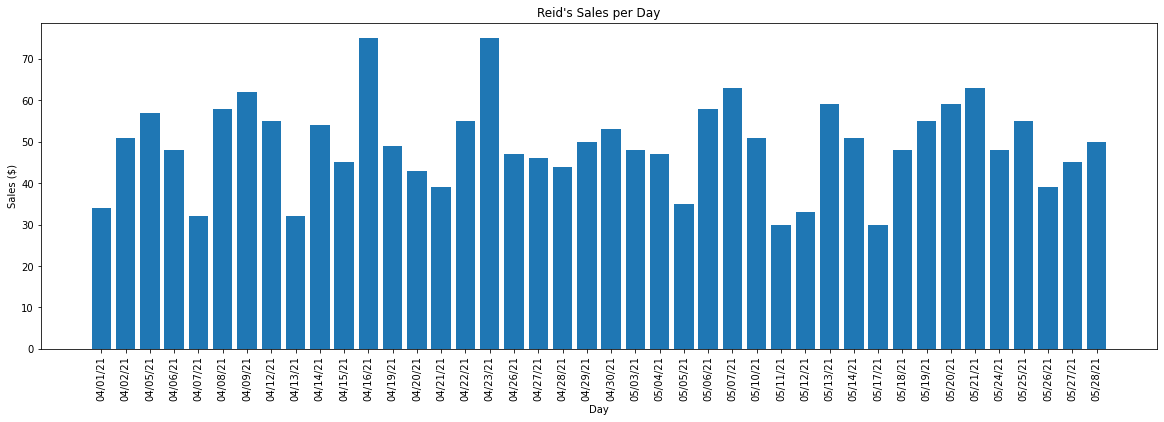

In [87]:
x = range(len(ret))

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, [r[1] for r in ret], align="center")
axes.set_xticks(x)
axes.set_xticklabels([r[0] for r in ret])
axes.set_title( "Reid's Sales per Day")
axes.set_xlabel("Day")
axes.set_ylabel("Sales ($)")
plt.setp(axes.xaxis.get_majorticklabels(), rotation=90)

plt.show()
plt.close();